In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd /content/drive/My\ Drive/
%cd broutanlab_course/

Mounted at /content/drive
/content/drive/My Drive
/content/drive/My Drive/broutanlab_course


# Step 1: Extract embeddings from face dataset

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import pickle
import imutils
import cv2
import os
from imutils import paths

In [ ]:
# load our serialized face detector from disk
detector = cv2.dnn.readNetFromCaffe("deploy.prototxt.txt", "res10_300x300_ssd_iter_140000.caffemodel")

In [ ]:
# load our serialized face embedding model from disk
embedder = cv2.dnn.readNetFromTorch('openface.nn4.small2.v1.t7')

In [ ]:
# grab the paths to the input images in our dataset
imagePaths = list(paths.list_images('dataset3'))
# initialize our lists of extracted facial embeddings and
# corresponding people names
knownEmbeddings = []
knownNames = []
# initialize the total number of faces processed
total = 0

In [ ]:
# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
	# extract the person name from the image path
	print("[INFO] processing image {}/{}".format(i + 1,	len(imagePaths)))
	name = imagePath.split(os.path.sep)[-2]
	# load the image, resize it to have a width of 600 pixels (while
	# maintaining the aspect ratio), and then grab the image
	# dimensions
	image = cv2.imread(imagePath)
	image = imutils.resize(image, width=600)
	(h, w) = image.shape[:2]
  # construct a blob from the image
	imageBlob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300),
		(104.0, 177.0, 123.0), swapRB=False, crop=False)
	# apply OpenCV's deep learning-based face detector to localize
	# faces in the input image
	detector.setInput(imageBlob)
	detections = detector.forward()
  # ensure at least one face was found
	if len(detections) > 0:
		# we're making the assumption that each image has only ONE
		# face, so find the bounding box with the largest probability
		i = np.argmax(detections[0, 0, :, 2])
		confidence = detections[0, 0, i, 2]
		# ensure that the detection with the largest probability also
		# means our minimum probability test (thus helping filter out
		# weak detections)
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the face
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")
			# extract the face ROI and grab the ROI dimensions
			face = image[startY:endY, startX:endX]
			(fH, fW) = face.shape[:2]
			# ensure the face width and height are sufficiently large
			if fW < 20 or fH < 20:
				continue
      # construct a blob for the face ROI, then pass the blob
			# through our face embedding model to obtain the 128-d
			# quantification of the face
			faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255,(96, 96), (0, 0, 0), swapRB=True, crop=False)
			embedder.setInput(faceBlob)
			vec = embedder.forward()
			# add the name of the person + corresponding face
			# embedding to their respective lists
			knownNames.append(name)
			knownEmbeddings.append(vec.flatten())
			total += 1

[INFO] processing image 1/18
[INFO] processing image 2/18
[INFO] processing image 3/18
[INFO] processing image 4/18
[INFO] processing image 5/18
[INFO] processing image 6/18
[INFO] processing image 7/18
[INFO] processing image 8/18
[INFO] processing image 9/18
[INFO] processing image 10/18
[INFO] processing image 11/18
[INFO] processing image 12/18
[INFO] processing image 13/18
[INFO] processing image 14/18
[INFO] processing image 15/18
[INFO] processing image 16/18
[INFO] processing image 17/18
[INFO] processing image 18/18


In [ ]:
# dump the facial embeddings + names to disk
print("[INFO] serializing {} encodings...".format(total))
data = {"embeddings": knownEmbeddings, "names": knownNames}
f = open('embedings.pickle', "wb")
f.write(pickle.dumps(data))
f.close()

[INFO] serializing 16 encodings...


#Step 2: Train face recognition model

In [ ]:
recognizer = pickle.loads(open(args["recognizer"], "rb").read())
le = pickle.loads(open(args["le"], "rb").read())

In [ ]:
print("[INFO] loading face embeddings...")
data = pickle.loads(open('embedings.pickle', "rb").read())
# encode the labels
print("[INFO] encoding labels...")
le = LabelEncoder()
labels = le.fit_transform(data["names"])

[INFO] loading face embeddings...
[INFO] encoding labels...


In [ ]:
print("[INFO] training model...")
recognizer = SVC(C=1.0, kernel="linear", probability=True)
recognizer.fit(data["embeddings"], labels)

[INFO] training model...


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
f = open('recognizer.pickle', "wb")
f.write(pickle.dumps(recognizer))
f.close()
# write the label encoder to disk
f = open('le.pickle', "wb")
f.write(pickle.dumps(le))
f.close()

#Step 3: Recognize faces with OpenCV

In [ ]:
print("[INFO] loading face detector...")
# load our serialized face detector from disk
detector = cv2.dnn.readNetFromCaffe("deploy.prototxt.txt", "res10_300x300_ssd_iter_140000.caffemodel")
# load our serialized face embedding model from disk
print("[INFO] loading face recognizer...")
embedder = cv2.dnn.readNetFromTorch('openface.nn4.small2.v1.t7')

# load the actual face recognition model along with the label encoder
recognizer = pickle.loads(open('recognizer.pickle', "rb").read())
le = pickle.loads(open('le.pickle', "rb").read())

[INFO] loading face detector...
[INFO] loading face recognizer...


In [ ]:
# load the image, resize it to have a width of 600 pixels (while
# maintaining the aspect ratio), and then grab the image dimensions
image = cv2.imread('pic1.png')
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]
# construct a blob from the image
imageBlob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300),
	(104.0, 177.0, 123.0), swapRB=False, crop=False)
# apply OpenCV's deep learning-based face detector to localize
# faces in the input image
detector.setInput(imageBlob)
detections = detector.forward()

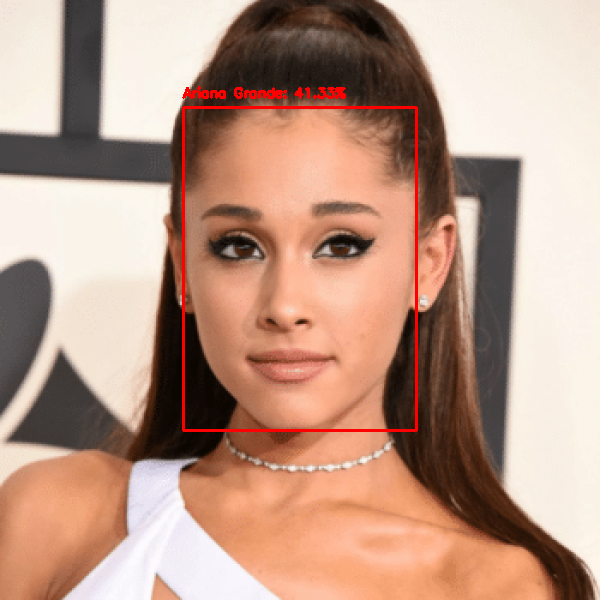

-1

In [ ]:
# loop over the detections
for i in range(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with the
	# prediction
	confidence = detections[0, 0, i, 2]
	# filter out weak detections
	if confidence > 0.5:
		# compute the (x, y)-coordinates of the bounding box for the
		# face
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")
		# extract the face ROI
		face = image[startY:endY, startX:endX]
		(fH, fW) = face.shape[:2]
		# ensure the face width and height are sufficiently large
		if fW < 20 or fH < 20:
			continue
    # construct a blob for the face ROI, then pass the blob
		# through our face embedding model to obtain the 128-d
		# quantification of the face
		faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255, (96, 96),
			(0, 0, 0), swapRB=True, crop=False)
		embedder.setInput(faceBlob)
		vec = embedder.forward()
		# perform classification to recognize the face
		preds = recognizer.predict_proba(vec)[0]
		j = np.argmax(preds)
		proba = preds[j]
		name = le.classes_[j]
    # draw the bounding box of the face along with the associated
		# probability
		text = "{}: {:.2f}%".format(name, proba * 100)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(image, (startX, startY), (endX, endY),
			(0, 0, 255), 2)
		cv2.putText(image, text, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
# show the output image
cv2_imshow(image)
cv2.waitKey(0)

In [ ]:
imagePaths = list(paths.list_images('test3'))
for (i, imagePath) in enumerate(imagePaths):
  image = cv2.imread(imagePath)
  image = imutils.resize(image, width=600)
  (h, w) = image.shape[:2]
  imageBlob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300),(104.0, 177.0, 123.0), swapRB=False, crop=False)
  detector.setInput(imageBlob)
  detections = detector.forward()
  for i in range(0, detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > 0.5:
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      (startX, startY, endX, endY) = box.astype("int")
      face = image[startY:endY, startX:endX]
      (fH, fW) = face.shape[:2]
      if fW < 20 or fH < 20:
        continue
      faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255, (96, 96),
        (0, 0, 0), swapRB=True, crop=False)
      embedder.setInput(faceBlob)
      vec = embedder.forward()
      preds = recognizer.predict_proba(vec)[0]
      j = np.argmax(preds)
      proba = preds[j]
      name = le.classes_[j]
      text = "{}: {:.2f}%".format(name, proba * 100)
      y = startY - 10 if startY - 10 > 10 else startY + 10
      cv2.rectangle(image, (startX, startY), (endX, endY),
        (0, 0, 255), 2)
      cv2.putText(image, text, (startX, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
  cv2_imshow(image)
  cv2.waitKey(0)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
6